In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('train.data', names=[i for i in range(41)])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2,-56,-0.33,-0.09,0.90,0.2,-11,12,0.004,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.032,-0.0009
1,470,-39,0.02,0.12,0.39,-0.6,-12,8,0.009,-1.6,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.034,-0.0011
2,165,4,0.14,0.14,0.78,0.4,-11,-9,-0.003,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,1.0,0.034,-0.0012
3,-113,5,-0.12,0.11,1.06,0.6,-10,-7,-0.008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.033,-0.0011
4,-411,-21,-0.17,0.07,1.33,-0.6,-11,0,0.002,0.1,...,0.0,0.0,0.0,0.0,0.0,-0.002,0.0,0.9,0.032,-0.0008


In [ ]:
df.info()

In [ ]:
class TreeNode(object):
    '''
    index : 树节点包含的样本索引
    Gain : 树节点的增益
    depth : 树节点的最大深度
    isleaf : 树节点是否为叶子节点
    feature_split : 树节点划分的特征索引
    value_split : 树节点的划分值
    child : 孩子节点包含的特征数据
    order : 该节点所包含的特征数据
    label : 若树节点为叶子节点，其为该节点的权重
    '''
    def __init__(self, index = None, child = [], Gain = 0, depth = 0):
        self.index = index
        self.Gain = Gain
        self.depth = depth
        self.isleaf = 0
        self.feature_split = None
        self.value_split = None
        self.child = child
        self.order = None
        self.label = 0
        
    '''
    改变树节点的属性（特征索引，划分值，所包含的特征数据）
    '''
    def change_feature(self, feature, value, best_order):
        self.feature_split = feature
        self.value_split = value
        self.order = best_order
    '''
    设置权重
    '''
    def set_label(self, label):
        self.label = label

class DecisionTree(object):
    '''
    root : 决策树根节点
    min_Gain : 划分的最小增益
    max_depth : 决策树的最大深度
    gamma : 叶子节点树的正则化系数
    Lambda : 二次项的正则化系数
    x : 训练样本特征值
    y : 训练样本权重
    labels : 训练样本权重（去重）
    loss : 预测损失
    min_splits : 最小的划分区间数
    '''
    def __init__(self, max_depth = 0, min_splits = 0, min_Gain = 0, gamma = 0, Lambda = 0): # 初始化回归树
        self.root = None
        self.min_Gain = min_Gain
        self.max_depth = max_depth
        self.gamma = gamma
        self.Lambda = Lambda
        self.x = None
        self.y = None
        self.labels = None
        self.loss = None
        self.min_splits = min_splits
    
    '''
    对loss求偏导
    '''
    def partial_loss(self, ytrue, ypred):
        return 2 * (ypred - ytrue)
    
    '''
    # 非基学习器的多特征选择决策树
    def Ent(self, index):
        if len(index) == 0:
            return 0
        #index = [i + 1 for i in index]
        y_temp = self.y.loc[index]
        freq = y_temp.value_counts()
        
        new_index = np.array(freq).nonzero()
        freq = np.array(freq)
        freq = freq[new_index]
        freq = freq/float(freq.sum())
        return -np.sum(freq * np.log(freq))
    '''
    
    '''
    获得最佳feature和split
    '''
    def _get_best_split(self, node, n): 
        #防止特征索引越界
        if n >= self.x.shape[1]:
            n = n % self.x.shape[1]
        
        #初始化参数
        index = node.index
        best_Gain = -np.inf
        best_splits = []
        best_value = None
        
        #计算父节点得分
        G = np.sum(self.__g[0][index])
        H = np.sum(self.__h[index])
        obj1 = -1 / 2 * G ** 2 / (H + self.Lambda) + self.gamma
        
        #划分所需数据
        data = self.x.loc[index]
        
        '''
        # 非基学习器的多特征选择决策树
        for i, j in enumerate(list(self.x)):
            values = self.x.iloc[index, i].unique().tolist()
            if len(values) == 1:
                continue
            splits = []
            for value in values:
                sub_indexs = data.index[data[j] == value].tolist()
                splits.append([sub_index for sub_index  in sub_indexs])
            if min(map(len, splits)) < self.min_splits:
                continue
            PH = 0
            for split in splits:
                PH += len(split)/len(index) * self.Ent(split)
            Gain = node.Ent - PH
            if Gain < self.min_Gain:
                continue
            if Gain > best_Gain:
                best_Gain = Gain
                best_splits = splits
                best_feature = j
                best_order = values
        '''
        #初始化参数
        Gleft = 0
        Hleft = 0
        Gright = 0 
        Hright = 0
        best_Gain = self.min_Gain
        values = self.x.iloc[index, n].unique().tolist()
        
        #对训练数据的权重进行升序排列
        values.sort()
        new_values = []
        
        #计算所有划分的得分，若此时的划分增益大于最大增益，则更新最大增益
        for i in range(len(values)):
            if i < len(values) - 1:
                new_values.append((values[i] + values[i + 1])/2.0)
        for value in values:
            splits = []
            sub_indexs1 = data.index[data[n] <= value].tolist()
            sub_indexs2 = data.index[data[n] > value].tolist()
            splits.append(sub_indexs1)
            splits.append(sub_indexs2)
            mark = 0
            for split in splits:
                if mark == 0:
                    for idx in split:
                        Gleft += self.__g[0][idx]
                        Hleft += self.__h[idx]
                        mark += 1
                else:
                    Gright = G - Gleft
                    Hright = H - Hleft
            obj2 = -1 / 2 * (Gleft ** 2 / (Hleft + self.Lambda + 1e-16) + Gright ** 2 / (Hright + self.Lambda + 1e-16)) + self.gamma
            Gain = obj1 - obj2
            if Gain > best_Gain:
                best_Gain = Gain
                best_splits = splits
                best_value = value
            
        #更新决策树节点的性质
        node.change_feature(n, best_value, values) 
        child_nodes = [TreeNode(index=split, Gain=best_Gain, depth=node.depth + 1) for split in best_splits]
        
        return child_nodes       
    
    '''
    训练决策树
    '''
    def fit(self, x, y, y_prior,n,learning_rate = 0.1):
        #初始化参数
        num_train = x.shape[0]
        root_index = range(x.count()[0])
        self.x = x
        self.y = y
        self.learning_rate = learning_rate
        y = np.array(y)
        
        #计算loss的一阶导数和二阶导数
        self.__g = np.array( [self.partial_loss(y[i], y_prior[i]) for i in range(num_train)]).T
        self.__h = np.array([2 for i in range(num_train)]).T
        
        #设置根节点
        self.root = TreeNode(index=root_index, depth=0)
        
        #非递归形式划分决策树
        #划分停止策略1 ： 若树节点等于决策树最大深度，则停止划分
        #划分停止策略2 ： 划分后增益小于某个阈值则停止划分
        queue = []
        queue.append(self.root)
        while(queue):
            node = queue.pop()
            if node.depth < self.max_depth and node.isleaf == 0: #or node.Gain < self.min_Gain:
                node.child = self._get_best_split(node, n)
                if not node.child:
                    #sub_index = [i for i in node.index]
                    #temp = self.y.loc[sub_index]
                    #node.set_label(np.array(temp.mode()))
                    node.isleaf = 1
                    G, H = np.sum(self.__g[0][node.index]), np.sum(self.__h[node.index])
                    node.set_label(self.learning_rate * -G / (H + self.Lambda + 1e-16))
                queue += node.child
            else:
                #sub_index = [i for i in node.index]
                #temp = self.y.loc[sub_index]
                #node.set_label(np.array(temp.mode()))
                node.isleaf = 1
                G, H = np.sum(self.__g[0][node.index]), np.sum(self.__h[node.index])
                node.set_label(self.learning_rate * -G / (H + self.Lambda + 1e-16))
    
    '''
    预测一个样本
    '''
    def _predict(self, test_x): 
        node = self.root
        
        #通过条件判断递至根节点，获取权重
        while node.child:
            temp = node.feature_split
            if test_x[temp] <= node.value_split:
                node = node.child[0]
            else:
                node = node.child[1]
        label = node.label
        
        return label
    
    '''
    预测多条样本
    '''
    def predict(self, test_datas):
        num_test = test_datas.shape[0]
        labels = np.zeros(num_test)
        for i in range(num_test):
            test_x = list(test_datas.iloc[i,:])
            labels[i] = (self._predict(test_x))
        return labels




In [ ]:
class XGBoost(object):
    '''
    epoch : 迭代次数
    max_depth : 决策树最大深度
    learning_rate : 学习率
    gamma : 叶子节点树的正则化系数
    Lambda : 二次项的正则化系数
    trees : 预测所需所有决策树
    R2s : 记录训练过程R2的变化
    loss : 记录训练过程loss的变化
    '''
    def __init__(self,epoch=100, max_depth=6, learning_rate=0.3, gamma=0,Lambda=1.0):
        self.epoch = epoch
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.Lambda = Lambda
        self.trees = []
        self.R2s = []
        self.loss = {'train': [], 'val':[]}
        
    '''
    计算MSE
    '''
    def MSE(self, y_true, y_pre):
        y_pre = np.array(y_pre).reshape(np.array(y_true).shape[0], 1)
        return np.sum((np.array(y_true) - y_pre)**2) / np.array(y_true).shape[0]
    
    '''
    计算RMSE
    '''
    def RMSE(self, y_true, y_pre):
        return np.sqrt(self.MSE(y_true, y_pre))
    
    '''
    计算R2
    '''
    def R2(self, y_true, y_pre):
        #print(np.var(np.array(y_true)))
        return 1 - self.MSE(y_true, y_pre) / np.var(np.array(y_true))
    
    '''
    计算并记录RMSE
    '''
    def cal_RMSE(self, y_true, y_pre, flag = 'train'):
        loss = self.RMSE(y_true, y_pre)
        self.loss[flag].append(loss)
        return loss
    
    '''
    以决策树为基学习器训练模型
    '''
    def fit(self, x_train, y_train, eval_test_x = None, eval_test_y = None, ESR = None):
        #初始化参数
        num_train = x_train.shape[0]
        if eval_test_x is not None:
            eval_y = np.zeros(eval_test_y.size)
            if ESR:
                min_loss = np.inf
                iter = 0
        temp_y = np.zeros(num_train)

        #迭代训练
        #停止策略1 ： 学习最多 epoch个颗决策树后停下来
        #停止策略2 ： 设置验证集，若选择ESR次训练得到的决策树都无法降低loss，则停止
        for i in range(self.epoch):
            tree = DecisionTree(max_depth = self.max_depth, min_splits=2, min_Gain=1e-10, gamma=self.gamma, Lambda=self.Lambda)
            n = np.random.randint(0, 40)
            #print("train epoch {}".format(i + 1))
            #print("feature {}".format(n))
            self.learning_rate = self.learning_rate * 0.95
            tree.fit(x_train, y_train, temp_y, n, learning_rate=self.learning_rate)
            self.trees.append(tree)
            temp_y += tree.predict(x_train)
            self.cal_RMSE(y_train, temp_y, flag='train')
            if eval_test_x is not None:
                eval_y += tree.predict(eval_test_x)
                loss = self.cal_RMSE(eval_test_y, eval_y, flag='val')
                R2 = self.R2(eval_test_y, eval_y)
                self.R2s.append(R2)              
                if ESR:
                    if loss < min_loss:
                        min_loss = loss
                        iter = 0
                        #print("eval_test_loss {}".format(loss))
                        #print("eval_test_R2 {}".format(R2))
                    else:
                        temp_y -= tree.predict(x_train)
                        self.trees.pop()
                        self.loss['val'].pop()
                        self.loss['train'].pop()
                        iter += 1
                        if iter >= ESR:
                            break
        return self
    
    #预测样本
    def predict(self, x_test):
        pred = np.zeros(x_test.shape[0])
        for tree in self.trees:
            pred += tree.predict(x_test)
        return pred
    

In [ ]:
#分隔数据集
X = df.iloc[:, 0 : 40]
y = df.iloc[:, 40 : 41 ]
X_train = X.iloc[0:6000, :]
Y_train = y.iloc[0:6000, :]
eval_test_x = X.iloc[3000:6000, :]
eval_test_y = y.iloc[3000:6000, :]
X_test = X.iloc[6000:, :]
Y_test = y.iloc[6000:, :]

In [26]:
#比较根据不同超参数训练得到的模型的RMSE，R2
for i in range(3):
    for j in range(2):
        for k in range(3):
            for l in range(2):
                xgb =XGBoost(epoch=100, max_depth= 5 * (10 ** i) , learning_rate= 10 ** (-j), gamma=10 ** (-k), Lambda=0.1 * (10 ** l ))
                xgb.fit(X_train, Y_train, eval_test_x=eval_test_x, eval_test_y =eval_test_y, ESR=20)
                ypred_train = xgb.predict(X_train)
                ypred_test = xgb.predict(X_test)
                print('max_depth=:{}  learning_rate=:{}  gamma=:{}  Lambda=:{}  train RMSE=:{}  train R2=:{}  test RMSE=:{}  test R2=:{}'.format(5 * (10 ** i), 10 ** (-j), 10 ** (-k), 0.1 * 10 ** l, xgb.RMSE(np.array(Y_train), ypred_train),xgb.R2(np.array(Y_train), ypred_train),xgb.RMSE(np.array(Y_test), ypred_test),xgb.R2(np.array(Y_test), ypred_test) ))



max_depth=:5  learning_rate=:1  gamma=:1  Lambda=:0.1  train RMSE=:0.0002297286171434731  train R2=:0.6805371306289851  test RMSE=:0.00026162126777026914  test R2=:0.5902786480292521
max_depth=:5  learning_rate=:1  gamma=:1  Lambda=:1.0  train RMSE=:0.0002850708804969112  train R2=:0.5080783851677066  test RMSE=:0.00030738827917744675  test R2=:0.43438995626978183
max_depth=:5  learning_rate=:1  gamma=:0.1  Lambda=:0.1  train RMSE=:0.0002578536437970132  train R2=:0.5975270126720843  test RMSE=:0.00029345909074202797  test R2=:0.48448935151645145
max_depth=:5  learning_rate=:1  gamma=:0.1  Lambda=:1.0  train RMSE=:0.0001898220848405809  train R2=:0.7818859361880828  test RMSE=:0.00023883441623827074  test R2=:0.6585427614634756
max_depth=:5  learning_rate=:1  gamma=:0.01  Lambda=:0.1  train RMSE=:0.00027873335143491874  train R2=:0.5297074870668421  test RMSE=:0.000309824257399044  test R2=:0.4253897876652937
max_depth=:5  learning_rate=:1  gamma=:0.01  Lambda=:1.0  train RMSE=:0.00031

In [ ]:
#设置一组超参数进行训练
xgb =XGBoost(epoch=500, max_depth= 50 , learning_rate= 1, gamma=1, Lambda=1)
xgb.fit(X_train, Y_train, eval_test_x=eval_test_x, eval_test_y =eval_test_y, ESR=20)
ypred_train = xgb.predict(X_train)
ypred_test = xgb.predict(X_test)
print('max_depth=:{}  learning_rate=:{}  gamma=:{}  Lambda=:{}  train RMSE=:{}  train R2=:{}  test RMSE=:{}  test R2=:{}'.format(30, 1, 0.1, 1.0, xgb.RMSE(np.array(Y_train), ypred_train),xgb.R2(np.array(Y_train), ypred_train),xgb.RMSE(np.array(Y_test), ypred_test),xgb.R2(np.array(Y_test), ypred_test) ))

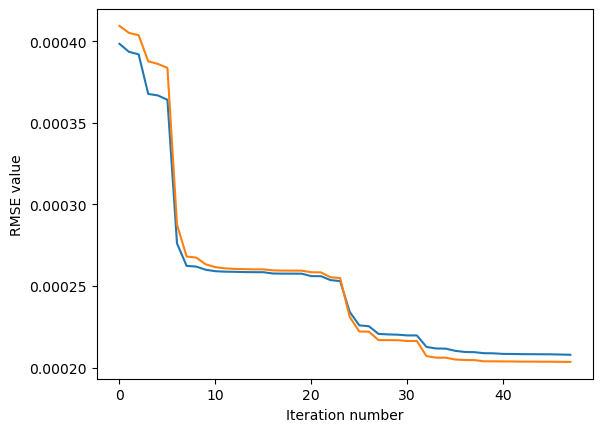

In [33]:
#绘制loss变化折线图
plt.plot(xgb.loss['train'])
plt.plot(xgb.loss['val'])
plt.xlabel('Iteration number')
plt.ylabel('RMSE value')
plt.show()